<a href="https://colab.research.google.com/github/Itskindastrange/HOTDOG-NOTHOTDOG/blob/main/HotDog_vs_Not_HotDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import time
import copy
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import tensorflow_datasets as tfds

In [2]:
#using food 101 from tf
#hotdog is 55

ds, ds_info = tfds.load('food101',shuffle_files=True,as_supervised=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JK43JT_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.JK43JT_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [4]:
train_ds, valid_ds = ds['train'], ds['validation']

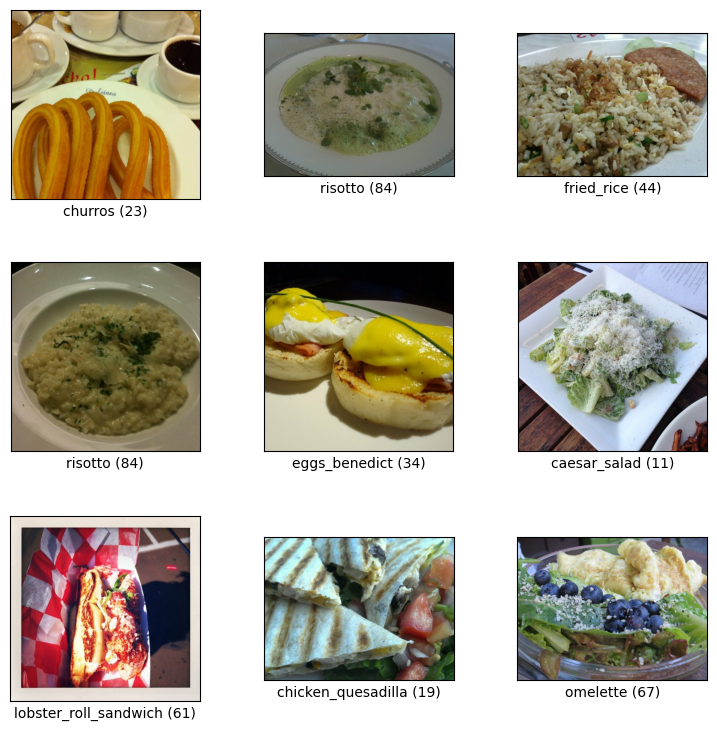

In [5]:
fig = tfds.show_examples(train_ds, ds_info)

In [6]:
MAX_SIDE_LENGTH = 128
HOT_DOG_LABEL = 55

train_ds = train_ds.map(
    lambda image, label: (
        tf.cast(tf.image.resize(image, [MAX_SIDE_LENGTH, MAX_SIDE_LENGTH]),dtype=tf.int32),
        tf.cast( label == HOT_DOG_LABEL, dtype=tf.int32)
    )
)

valid_ds = valid_ds.map(
    lambda image, label: (
        tf.cast(tf.image.resize(image, [MAX_SIDE_LENGTH, MAX_SIDE_LENGTH]),dtype=tf.int32),
        tf.cast( label == HOT_DOG_LABEL, dtype=tf.int32)
    )
)

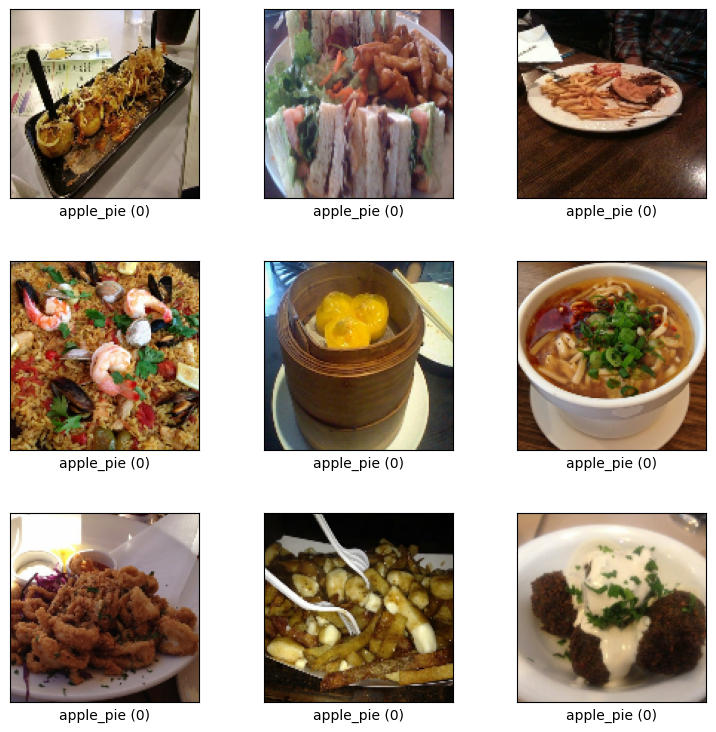

In [7]:
fig = tfds.show_examples(train_ds, ds_info)

In [8]:
train_hd_size, valid_hd_size = 750,250
train_hotdogs = train_ds.filter(lambda image, label: label == 1).repeat(3)
train_not_hotdogs = train_ds.filter(lambda image, label: label == 0)

In [9]:
valid_hotdogs = valid_ds.filter(lambda image, label: label == 1).repeat(3)
valid_not_hotdogs = valid_ds.filter(lambda image, label: label == 0)

In [10]:
#data pipeline

batch_size = 16
train_ds = tf.data.Dataset.sample_from_datasets([train_hotdogs, train_not_hotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
train_ds = train_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

valid_ds = tf.data.Dataset.sample_from_datasets([valid_hotdogs, valid_not_hotdogs],
                                                [0.5,0.5],
                                                stop_on_empty_dataset=True)
valid_ds =  valid_ds.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

# NN

In [15]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [17]:
random.seed(0)
model = models.Sequential()
model.add(layers.Rescaling(1./255))
model.add(data_augmentation)
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=[MAX_SIDE_LENGTH,MAX_SIDE_LENGTH, 3]))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

In [18]:
lr = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.keras.losses.BinaryCrossentropy(),                #from_logits=True in BCENTROPY IF SIGMOID NOT USED BEFORE IN LAST LAYER TO PROJECT OP TO 0 AND 1
              metrics=['accuracy'])

In [19]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=epochs
)

Epoch 1/50
278/278 [==============================] - 420s 1s/step - loss: 1.4564 - accuracy: 0.5303 - val_loss: 1.2128 - val_accuracy: 0.5409
Epoch 2/50
278/278 [==============================] - 6s 23ms/step - loss: 1.0753 - accuracy: 0.5690 - val_loss: 0.9677 - val_accuracy: 0.5699
Epoch 3/50
278/278 [==============================] - 6s 22ms/step - loss: 0.9047 - accuracy: 0.5816 - val_loss: 0.8545 - val_accuracy: 0.5834
Epoch 4/50
278/278 [==============================] - 6s 22ms/step - loss: 0.8235 - accuracy: 0.5800 - val_loss: 0.7988 - val_accuracy: 0.5881
Epoch 5/50
278/278 [==============================] - 6s 23ms/step - loss: 0.7786 - accuracy: 0.5991 - val_loss: 0.7596 - val_accuracy: 0.6131
Epoch 6/50
278/278 [==============================] - 6s 22ms/step - loss: 0.7465 - accuracy: 0.6135 - val_loss: 0.7233 - val_accuracy: 0.6658
Epoch 7/50
278/278 [==============================] - 6s 23ms/step - loss: 0.7263 - accuracy: 0.6211 - val_loss: 0.7060 - val_accuracy: 0.6651

In [20]:
model.save('saved_model/my_model')
model.save("model.h5")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in valid_ds.take(1):
  images = image_batch
  labels = label_batch

<Figure size 1000x1000 with 0 Axes>

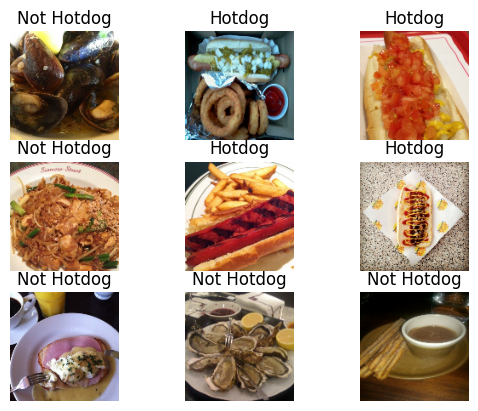

In [22]:
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(images[i])
  plt.axis("off")


  if labels[i] == 1:
    plt.title("Hotdog")
  else:
    plt.title("Not Hotdog")


In [23]:
labels[:9]

<tf.Tensor: shape=(9,), dtype=int32, numpy=array([0, 1, 1, 0, 1, 1, 0, 0, 0], dtype=int32)>